## Load Datasets

### MalDIST

In [2]:
import pandas as pd
balanced_data = pd.read_csv("../Datasets/Maldist_balanced1.csv", sep=",")

X_maldist = balanced_data.drop(columns=['label'])
y_maldist = balanced_data['label']

### JA4

In [3]:
import pandas as pd 
import numpy as np


desktop_malware = pd.read_csv('../Datasets/JA4/Dataset2/desktop-malware.csv', sep=';')
desktop_apps_1 = pd.read_csv('../Datasets/JA4/Dataset2/desktop-apps.csv', sep=';')
desktop_apps_2 = pd.read_csv('../Datasets/JA4/Dataset1/Benign.csv', sep=';')
desktop_apps_3 = pd.read_csv('../Datasets/JA4/Dataset2/mydesktop-apps.csv', sep=';')
print(len(desktop_apps_3))

mobile_malware = pd.read_csv('../Datasets/JA4/Dataset2/mobile-malware.csv', sep=';')
mobile_apps = pd.read_csv('../Datasets/JA4/Dataset2/mobile-apps.csv', sep=';')

drop_families = ["Sodinokibi", "Hawkeye", "Nanocore"]
desktop_malware = desktop_malware[~desktop_malware['AppName'].isin(drop_families)]


desktop_malware['label'] = 'DM'
desktop_apps_1['label'] = 'DA'
desktop_apps_2['label'] = 'DA'  # Asignamos DA si son aplicaciones benignas de escritorio
desktop_apps_3['label'] = 'DA'
mobile_malware['label'] = 'MM'
mobile_apps['label'] = 'MA'

df_combined = pd.concat([
    desktop_malware,
    desktop_apps_1,
    desktop_apps_2,
    desktop_apps_3,
    #mobile_malware,
    #mobile_apps
], ignore_index=True)


df_hashing = df_combined.drop(columns=['SrcIP', 'DstIP', 'SrcPort', 'DstPort', 'OrgName', 'JA3hash', 'JA3Shash', 'Version', 'Issuer', 'Subject'])

3766


In [4]:
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
y_ja4 = label_encoder.fit_transform(df_combined['label'])

hasher = FeatureHasher(n_features=1024, input_type='string')
X_ja4 = hasher.fit_transform(df_combined[['JA4hash', 'JA4Shash']].astype(str).values.tolist())

## Balance

In [5]:
import numpy as np
from scipy.sparse import issparse

# Asegurar que X_maldist sea NumPy array
if hasattr(X_maldist, 'values'):
    X_maldist = X_maldist.values  # Para DataFrames de Pandas

# Obtener mínimo de muestras
min_samples = min(X_ja4.shape[0], X_maldist.shape[0])

# Recortar JA4 (sparse)
X_ja4 = X_ja4[:min_samples, :] if issparse(X_ja4) else X_ja4[:min_samples]

# Recortar MalDIST (NumPy array)
X_maldist = X_maldist[:min_samples, :] if X_maldist.ndim > 1 else X_maldist[:min_samples]

# Recortar etiquetas
y = y_ja4[:min_samples]

# Verificación
print(f"JA4: {X_ja4.shape}, MalDIST: {X_maldist.shape}, Etiquetas: {len(y)}")

JA4: (11815, 1024), MalDIST: (11815, 198), Etiquetas: 11815


In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

# Generar índices comunes
indices = np.arange(len(y))  # Usa len(y) o X_ja4.shape[0]
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    indices, y, test_size=0.3, stratify=y, random_state=42
)

# Dividir JA4 y MalDIST usando los mismos índices
X_train_ja4 = X_ja4[X_train_idx]
X_test_ja4 = X_ja4[X_test_idx]
X_train_maldist = X_maldist[X_train_idx]
X_test_maldist = X_maldist[X_test_idx]

print(f"Entrenamiento - JA4: {X_train_ja4.shape}, MalDIST: {X_train_maldist.shape}, Etiquetas: {len(y_train)}")
print(f"Prueba - JA4: {X_test_ja4.shape}, MalDIST: {X_test_maldist.shape}, Etiquetas: {len(y_test)}")

Entrenamiento - JA4: (8270, 1024), MalDIST: (8270, 198), Etiquetas: 8270
Prueba - JA4: (3545, 1024), MalDIST: (3545, 198), Etiquetas: 3545


## Load ML Models

In [7]:
from tensorflow.keras.models import load_model
import joblib

try:
    rf = joblib.load('models/maldist.joblib')
    featureHasher = joblib.load('models/ja4.joblib')
    hybrid = load_model('models/hybrid_model.keras')
except Exception as e:
    print(f"Error al cargar modelos: {str(e)}")

2025-05-11 16:36:03.009317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-11 16:36:03.009354: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-05-11 16:36:04.706244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-05-11 16:36:04.706313: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-11 16:36:04.706328: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: fingopolo-HP-Pavilion-Laptop-14-ce3xxx
2025-05-11 16:36:04.706333: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostn

## Time measurements

In [8]:
import time
import numpy as np

def measure_inference(model, X_test, repetitions=100):
    
    # Warm-up
    for _ in range(10):
        _ = model.predict(X_test[:10])
    
    # Medición
    start_time = time.time()
    for _ in range(repetitions):
        _ = model.predict(X_test)
    end_time = time.time()
    
    avg_time = (end_time - start_time) / repetitions
    return avg_time

print(f"MALDIST TIME: {measure_inference(rf, X_test=X_test_maldist)}")
print(f"JA4 TIME: {measure_inference(featureHasher, X_test=X_test_ja4)}")

/home/fingopolo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/fingopolo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/fingopolo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/fingopolo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/fingopolo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home

MALDIST TIME: 0.03262322187423706
JA4 TIME: 0.06358406782150268


In [13]:
def measure_hybrid_inference(model, X_test_ja4, X_test_maldist, repetitions=100):
    
    # Warm-up
    for _ in range(10):
        _ = model.predict([X_test_ja4[:10], X_test_maldist[:10]])
    
    # Medición
    start_time = time.time()
    for _ in range(repetitions):
        _ = model.predict([X_test_ja4, X_test_maldist])
    end_time = time.time()
    
    avg_time = (end_time - start_time) / repetitions
    return avg_time

print(f"HYBRID TIME: {measure_hybrid_inference(hybrid, X_test_ja4=X_test_ja4, X_test_maldist=X_test_maldist)}")

HYBRID TIME: 0.2094031023979187


## BARPLOT

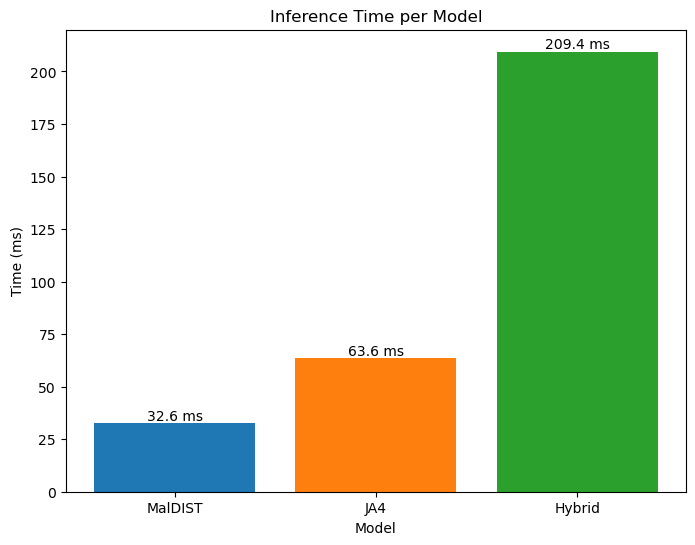

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo (REEMPLAZA con tus valores reales)
modelos = ['MalDIST', 'JA4', 'Hybrid']
tiempos_ms = [32.6232, 63.5840, 209.40310]  # Tiempos en milisegundos
inferencias_por_seg = [1/0.0326232, 1/0.0635840, 1/0.20940310]  # Inferencias por segundo

# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

## Gráfico 1: Tiempos de inferencia
bars1 = ax.bar(modelos, tiempos_ms, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_title('Inference Time per Model')
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Model')

# Añadir valores exactos encima de las barras
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f} ms',
            ha='center', va='bottom')


# Guardar como PDF
plt.savefig('comparativa_rendimiento.pdf', bbox_inches='tight')

# Mostrar el gráfico
plt.show()